# Task 3: Customer Churn Prediction (Bank Customers) 

In [1]:
# Import necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler, OneHotEncoder
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
import warnings
warnings.filterwarnings('ignore')

# Set style for better visualizations
plt.style.use('seaborn-v0_8')
sns.set_palette("husl")

In [2]:
# Load the dataset
# Note: You'll need to download the dataset from Kaggle or other sources
# For this example, I'll assume the dataset is available as 'Churn_Modelling.csv'
try:
    df = pd.read_csv('Churn_Modelling.csv')
    print("Dataset loaded successfully!")
except:
    print("Please download the dataset and update the file path")
    # Creating a sample dataset structure for demonstration
    data = {
        'RowNumber': range(1, 1001),
        'CustomerId': np.random.randint(100000, 999999, 1000),
        'Surname': ['Smith'] * 1000,
        'CreditScore': np.random.normal(650, 100, 1000),
        'Geography': np.random.choice(['France', 'Germany', 'Spain'], 1000),
        'Gender': np.random.choice(['Male', 'Female'], 1000),
        'Age': np.random.randint(18, 80, 1000),
        'Tenure': np.random.randint(0, 10, 1000),
        'Balance': np.random.normal(50000, 30000, 1000),
        'NumOfProducts': np.random.randint(1, 4, 1000),
        'HasCrCard': np.random.choice([0, 1], 1000),
        'IsActiveMember': np.random.choice([0, 1], 1000),
        'EstimatedSalary': np.random.normal(100000, 50000, 1000),
        'Exited': np.random.choice([0, 1], 1000, p=[0.8, 0.2])
    }
    df = pd.DataFrame(data)

print(f"Dataset shape: {df.shape}")
print("\nFirst few rows:")
print(df.head())

Dataset loaded successfully!
Dataset shape: (10000, 14)

First few rows:
   RowNumber  CustomerId   Surname  CreditScore Geography  Gender  Age  \
0          1    15634602  Hargrave          619    France  Female   42   
1          2    15647311      Hill          608     Spain  Female   41   
2          3    15619304      Onio          502    France  Female   42   
3          4    15701354      Boni          699    France  Female   39   
4          5    15737888  Mitchell          850     Spain  Female   43   

   Tenure    Balance  NumOfProducts  HasCrCard  IsActiveMember  \
0       2       0.00              1          1               1   
1       1   83807.86              1          0               1   
2       8  159660.80              3          1               0   
3       1       0.00              2          0               0   
4       2  125510.82              1          1               1   

   EstimatedSalary  Exited  
0        101348.88       1  
1        112542.58       0 

In [3]:
# Check for missing values
print("Missing values in each column:")
print(df.isnull().sum())

# Check data types
print("\nData types:")
print(df.dtypes)

# Drop unnecessary columns
# RowNumber, CustomerId, and Surname are not useful for prediction
df_clean = df.drop(['RowNumber', 'CustomerId', 'Surname'], axis=1, errors='ignore')

print(f"\nDataset shape after dropping unnecessary columns: {df_clean.shape}")

# Check for duplicate rows
print(f"\nNumber of duplicate rows: {df_clean.duplicated().sum()}")

# Basic statistics
print("\nDataset statistics:")
print(df_clean.describe())

Missing values in each column:
RowNumber          0
CustomerId         0
Surname            0
CreditScore        0
Geography          0
Gender             0
Age                0
Tenure             0
Balance            0
NumOfProducts      0
HasCrCard          0
IsActiveMember     0
EstimatedSalary    0
Exited             0
dtype: int64

Data types:
RowNumber            int64
CustomerId           int64
Surname             object
CreditScore          int64
Geography           object
Gender              object
Age                  int64
Tenure               int64
Balance            float64
NumOfProducts        int64
HasCrCard            int64
IsActiveMember       int64
EstimatedSalary    float64
Exited               int64
dtype: object

Dataset shape after dropping unnecessary columns: (10000, 11)

Number of duplicate rows: 0

Dataset statistics:
        CreditScore           Age        Tenure        Balance  NumOfProducts  \
count  10000.000000  10000.000000  10000.000000   10000.000000 

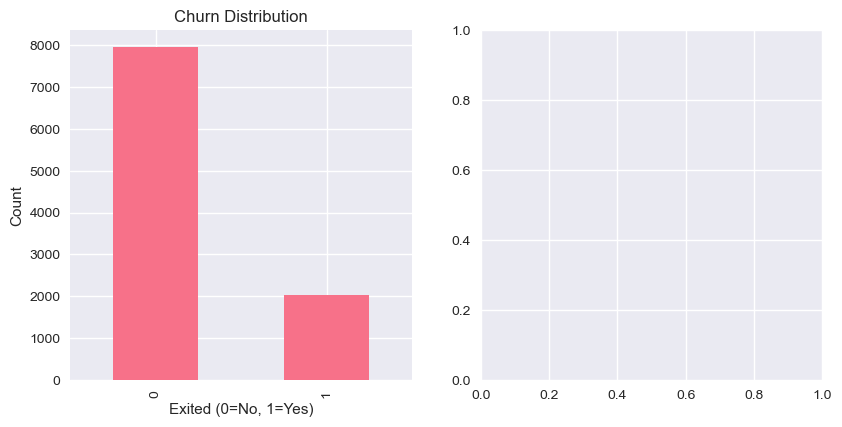

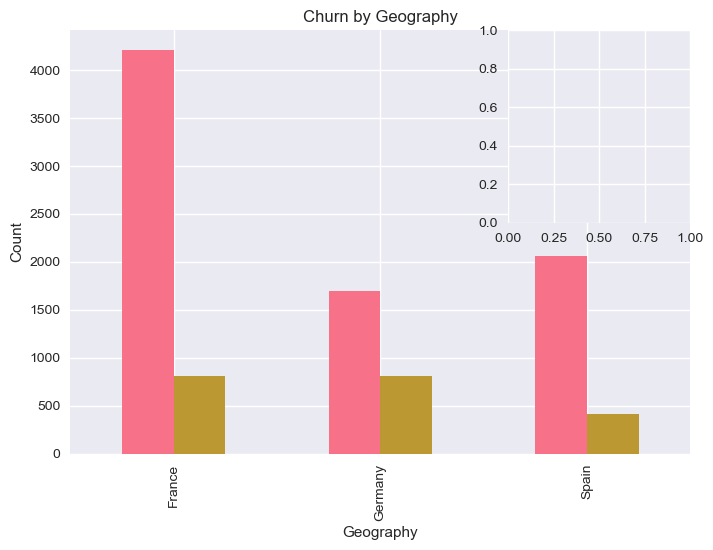

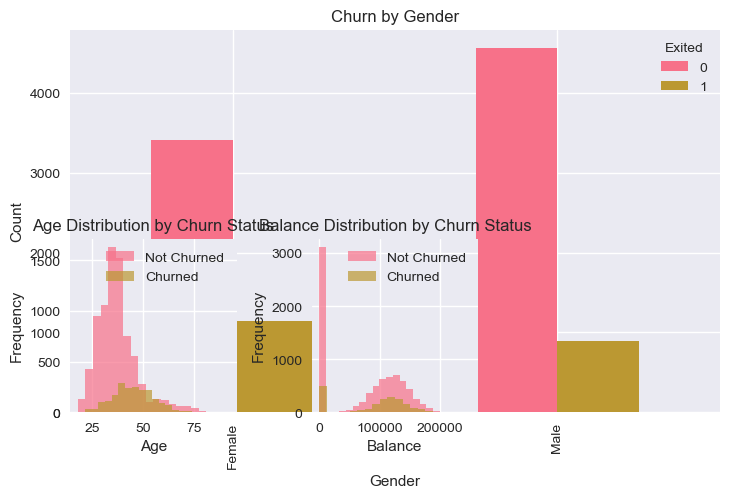

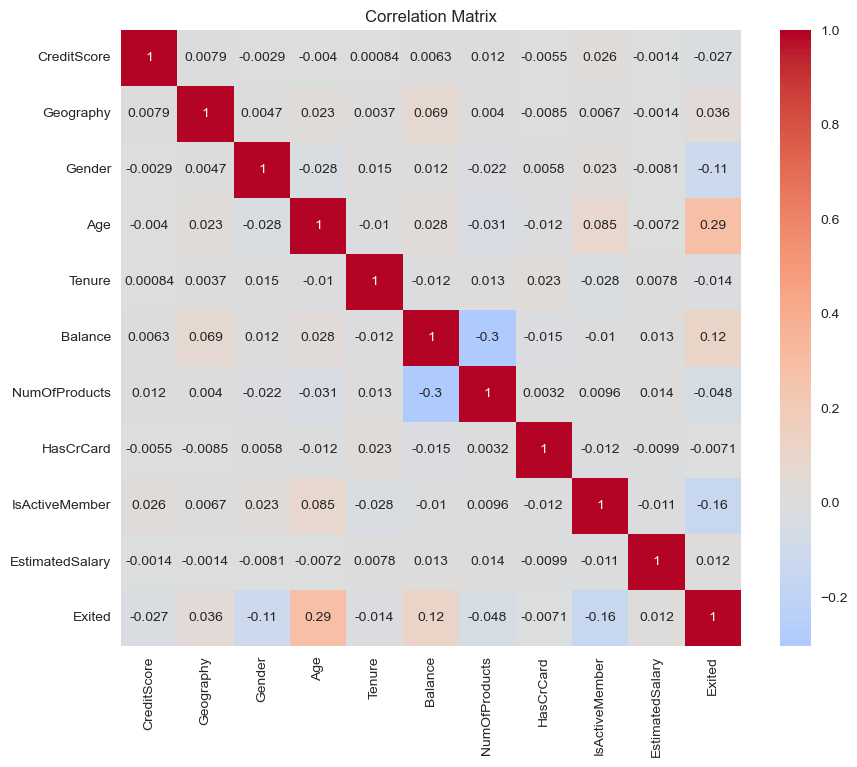

In [4]:
# Plot churn distribution
plt.figure(figsize=(15, 10))

plt.subplot(2, 3, 1)
df_clean['Exited'].value_counts().plot(kind='bar')
plt.title('Churn Distribution')
plt.xlabel('Exited (0=No, 1=Yes)')
plt.ylabel('Count')

# Geography vs Churn
plt.subplot(2, 3, 2)
pd.crosstab(df_clean['Geography'], df_clean['Exited']).plot(kind='bar')
plt.title('Churn by Geography')
plt.xlabel('Geography')
plt.ylabel('Count')

# Gender vs Churn
plt.subplot(2, 3, 3)
pd.crosstab(df_clean['Gender'], df_clean['Exited']).plot(kind='bar')
plt.title('Churn by Gender')
plt.xlabel('Gender')
plt.ylabel('Count')

# Age distribution by churn
plt.subplot(2, 3, 4)
df_clean[df_clean['Exited'] == 0]['Age'].hist(alpha=0.7, label='Not Churned', bins=20)
df_clean[df_clean['Exited'] == 1]['Age'].hist(alpha=0.7, label='Churned', bins=20)
plt.title('Age Distribution by Churn Status')
plt.xlabel('Age')
plt.ylabel('Frequency')
plt.legend()

# Balance distribution by churn
plt.subplot(2, 3, 5)
df_clean[df_clean['Exited'] == 0]['Balance'].hist(alpha=0.7, label='Not Churned', bins=20)
df_clean[df_clean['Exited'] == 1]['Balance'].hist(alpha=0.7, label='Churned', bins=20)
plt.title('Balance Distribution by Churn Status')
plt.xlabel('Balance')
plt.ylabel('Frequency')
plt.legend()

plt.tight_layout()
plt.show()

# Correlation matrix
plt.figure(figsize=(10, 8))
# First, let's create a temporary encoded version for correlation
df_temp = df_clean.copy()
le = LabelEncoder()
df_temp['Geography'] = le.fit_transform(df_temp['Geography'])
df_temp['Gender'] = le.fit_transform(df_temp['Gender'])

correlation_matrix = df_temp.corr()
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', center=0)
plt.title('Correlation Matrix')
plt.show()

In [5]:
# Create a copy of the cleaned dataset
df_encoded = df_clean.copy()

# Display categorical columns
print("Categorical columns:")
categorical_cols = df_encoded.select_dtypes(include=['object']).columns
print(categorical_cols)

# One-Hot Encoding for Geography (multiple categories)
print("\nBefore One-Hot Encoding:")
print(f"Geography unique values: {df_encoded['Geography'].unique()}")
print(f"Gender unique values: {df_encoded['Gender'].unique()}")

# Apply One-Hot Encoding to Geography
df_encoded = pd.get_dummies(df_encoded, columns=['Geography'], prefix='Geo')

# Apply Label Encoding to Gender (binary category)
le_gender = LabelEncoder()
df_encoded['Gender'] = le_gender.fit_transform(df_encoded['Gender'])
# Male = 1, Female = 0

print(f"\nDataset shape after encoding: {df_encoded.shape}")
print("\nColumns after encoding:")
print(df_encoded.columns.tolist())
print(f"\nGender encoding: {dict(zip(le_gender.classes_, le_gender.transform(le_gender.classes_)))}")

Categorical columns:
Index(['Geography', 'Gender'], dtype='object')

Before One-Hot Encoding:
Geography unique values: ['France' 'Spain' 'Germany']
Gender unique values: ['Female' 'Male']

Dataset shape after encoding: (10000, 13)

Columns after encoding:
['CreditScore', 'Gender', 'Age', 'Tenure', 'Balance', 'NumOfProducts', 'HasCrCard', 'IsActiveMember', 'EstimatedSalary', 'Exited', 'Geo_France', 'Geo_Germany', 'Geo_Spain']

Gender encoding: {'Female': np.int64(0), 'Male': np.int64(1)}


In [6]:
# Separate features and target variable
X = df_encoded.drop('Exited', axis=1)
y = df_encoded['Exited']

print(f"Features shape: {X.shape}")
print(f"Target shape: {y.shape}")
print(f"\nChurn rate: {y.mean():.2%}")

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

print(f"\nTraining set size: {X_train.shape[0]}")
print(f"Testing set size: {X_test.shape[0]}")

# Scale the features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

print("\nFeature scaling completed!")

Features shape: (10000, 12)
Target shape: (10000,)

Churn rate: 20.37%

Training set size: 8000
Testing set size: 2000

Feature scaling completed!



Training Random Forest...
Random Forest Accuracy: 0.8595

Classification Report for Random Forest:
              precision    recall  f1-score   support

           0       0.87      0.96      0.92      1593
           1       0.76      0.45      0.56       407

    accuracy                           0.86      2000
   macro avg       0.82      0.71      0.74      2000
weighted avg       0.85      0.86      0.84      2000



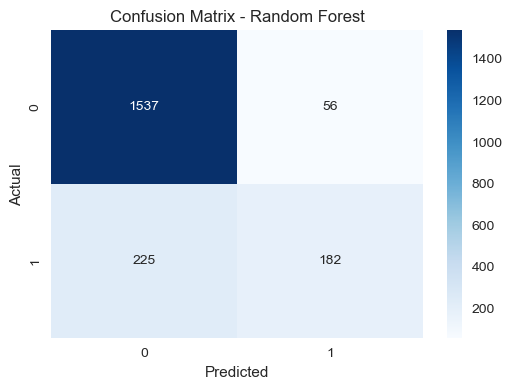


Training Logistic Regression...
Logistic Regression Accuracy: 0.8080

Classification Report for Logistic Regression:
              precision    recall  f1-score   support

           0       0.82      0.97      0.89      1593
           1       0.59      0.19      0.28       407

    accuracy                           0.81      2000
   macro avg       0.71      0.58      0.59      2000
weighted avg       0.78      0.81      0.77      2000



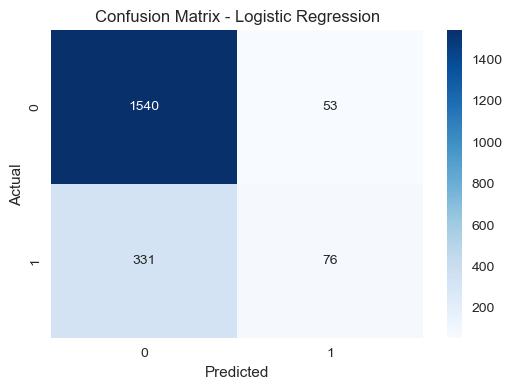

In [7]:
# Initialize models
models = {
    'Random Forest': RandomForestClassifier(n_estimators=100, random_state=42),
    'Logistic Regression': LogisticRegression(random_state=42)
}

# Train and evaluate models
results = {}

for name, model in models.items():
    print(f"\n{'='*50}")
    print(f"Training {name}...")
    
    if name == 'Logistic Regression':
        # Use scaled data for Logistic Regression
        model.fit(X_train_scaled, y_train)
        y_pred = model.predict(X_test_scaled)
        y_pred_proba = model.predict_proba(X_test_scaled)[:, 1]
    else:
        # Use unscaled data for tree-based models
        model.fit(X_train, y_train)
        y_pred = model.predict(X_test)
        y_pred_proba = model.predict_proba(X_test)[:, 1]
    
    # Calculate accuracy
    accuracy = accuracy_score(y_test, y_pred)
    
    results[name] = {
        'model': model,
        'predictions': y_pred,
        'probabilities': y_pred_proba,
        'accuracy': accuracy
    }
    
    print(f"{name} Accuracy: {accuracy:.4f}")
    print(f"\nClassification Report for {name}:")
    print(classification_report(y_test, y_pred))
    
    # Confusion Matrix
    plt.figure(figsize=(6, 4))
    cm = confusion_matrix(y_test, y_pred)
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
    plt.title(f'Confusion Matrix - {name}')
    plt.ylabel('Actual')
    plt.xlabel('Predicted')
    plt.show()

Feature Importance (Random Forest):
            feature  importance
2               Age    0.240321
8   EstimatedSalary    0.144367
0       CreditScore    0.142725
4           Balance    0.142318
5     NumOfProducts    0.127995
3            Tenure    0.082605
7    IsActiveMember    0.039820
10      Geo_Germany    0.022699
1            Gender    0.019172
6         HasCrCard    0.018334
9        Geo_France    0.010234
11        Geo_Spain    0.009410


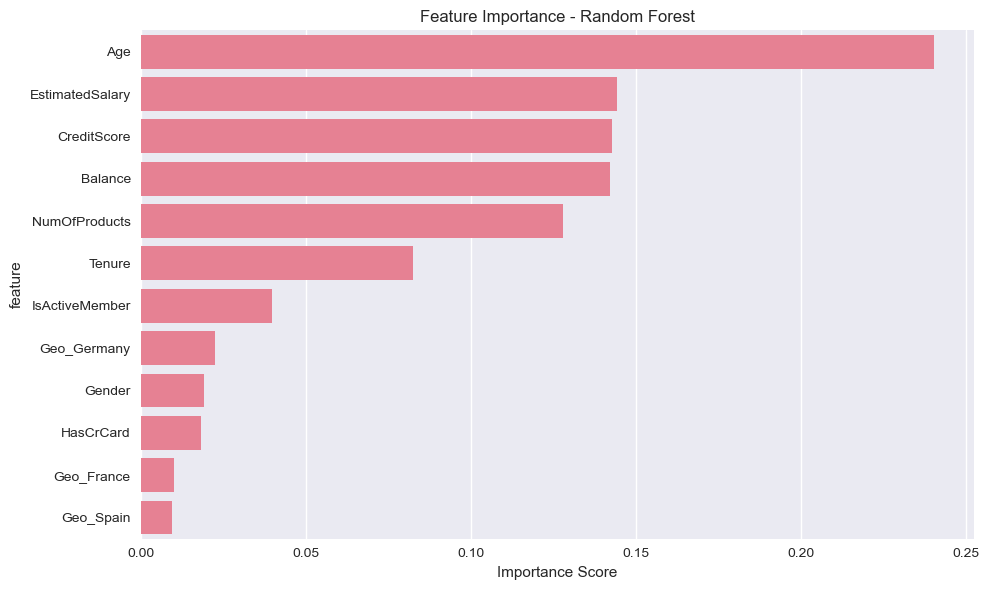


Feature Importance (Logistic Regression - Absolute Coefficients):
            feature  coefficient
2               Age     0.738899
7    IsActiveMember    -0.515396
1            Gender    -0.260854
10      Geo_Germany     0.244096
4           Balance     0.160344
9        Geo_France    -0.130455
11        Geo_Spain    -0.093632
0       CreditScore    -0.085973
5     NumOfProducts    -0.070560
8   EstimatedSalary     0.047749
6         HasCrCard    -0.032223
3            Tenure    -0.020121


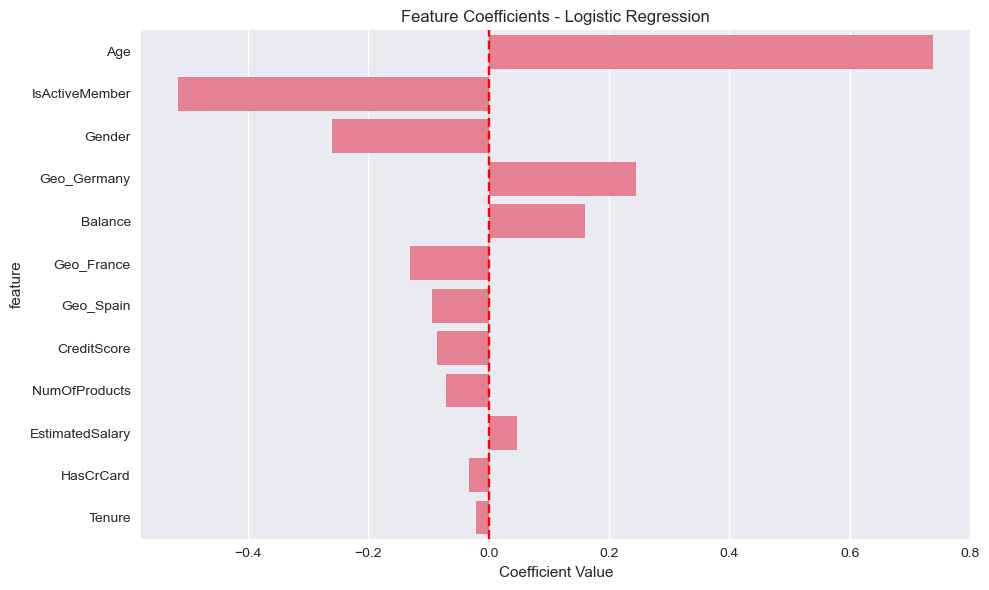

In [8]:
# Get the best model (Random Forest for feature importance)
best_model = results['Random Forest']['model']

# Feature importance from Random Forest
feature_importance = pd.DataFrame({
    'feature': X.columns,
    'importance': best_model.feature_importances_
}).sort_values('importance', ascending=False)

print("Feature Importance (Random Forest):")
print(feature_importance)

# Plot feature importance
plt.figure(figsize=(10, 6))
sns.barplot(data=feature_importance, x='importance', y='feature')
plt.title('Feature Importance - Random Forest')
plt.xlabel('Importance Score')
plt.tight_layout()
plt.show()

# For Logistic Regression (using scaled coefficients)
lr_model = results['Logistic Regression']['model']
lr_importance = pd.DataFrame({
    'feature': X.columns,
    'coefficient': lr_model.coef_[0],
    'abs_coefficient': np.abs(lr_model.coef_[0])
}).sort_values('abs_coefficient', ascending=False)

print("\nFeature Importance (Logistic Regression - Absolute Coefficients):")
print(lr_importance[['feature', 'coefficient']])

# Plot logistic regression coefficients
plt.figure(figsize=(10, 6))
sns.barplot(data=lr_importance, x='coefficient', y='feature')
plt.title('Feature Coefficients - Logistic Regression')
plt.xlabel('Coefficient Value')
plt.axvline(x=0, color='red', linestyle='--')
plt.tight_layout()
plt.show()

In [9]:
# Create a comprehensive analysis
print("="*60)
print("CUSTOMER CHURN ANALYSIS SUMMARY")
print("="*60)

print(f"\nOverall Churn Rate: {y.mean():.2%}")

# Key findings from feature importance
print("\nKEY FINDINGS:")
print("1. Top factors influencing churn (based on Random Forest):")
for i, row in feature_importance.head(5).iterrows():
    print(f"   - {row['feature']}: {row['importance']:.4f}")

print("\n2. Demographic Insights:")
# Geography impact
if 'Geo_France' in df_encoded.columns and 'Geo_Germany' in df_encoded.columns:
    france_churn = df_clean[df_clean['Geography'] == 'France']['Exited'].mean()
    germany_churn = df_clean[df_clean['Geography'] == 'Germany']['Exited'].mean()
    spain_churn = df_clean[df_clean['Geography'] == 'Spain']['Exited'].mean()
    print(f"   - Germany churn rate: {germany_churn:.2%}")
    print(f"   - France churn rate: {france_churn:.2%}")
    print(f"   - Spain churn rate: {spain_churn:.2%}")

# Gender impact
male_churn = df_clean[df_clean['Gender'] == 'Male']['Exited'].mean()
female_churn = df_clean[df_clean['Gender'] == 'Female']['Exited'].mean()
print(f"   - Female churn rate: {female_churn:.2%}")
print(f"   - Male churn rate: {male_churn:.2%}")

print("\n3. Behavioral Insights:")
# Active members vs inactive
active_churn = df_clean[df_clean['IsActiveMember'] == 1]['Exited'].mean()
inactive_churn = df_clean[df_clean['IsActiveMember'] == 0]['Exited'].mean()
print(f"   - Inactive members churn rate: {inactive_churn:.2%}")
print(f"   - Active members churn rate: {active_churn:.2%}")

# Credit card holders
cc_churn = df_clean[df_clean['HasCrCard'] == 1]['Exited'].mean()
no_cc_churn = df_clean[df_clean['HasCrCard'] == 0]['Exited'].mean()
print(f"   - Credit card holders churn rate: {cc_churn:.2%}")
print(f"   - Non-credit card holders churn rate: {no_cc_churn:.2%}")

CUSTOMER CHURN ANALYSIS SUMMARY

Overall Churn Rate: 20.37%

KEY FINDINGS:
1. Top factors influencing churn (based on Random Forest):
   - Age: 0.2403
   - EstimatedSalary: 0.1444
   - CreditScore: 0.1427
   - Balance: 0.1423
   - NumOfProducts: 0.1280

2. Demographic Insights:
   - Germany churn rate: 32.44%
   - France churn rate: 16.15%
   - Spain churn rate: 16.67%
   - Female churn rate: 25.07%
   - Male churn rate: 16.46%

3. Behavioral Insights:
   - Inactive members churn rate: 26.85%
   - Active members churn rate: 14.27%
   - Credit card holders churn rate: 20.18%
   - Non-credit card holders churn rate: 20.81%


In [11]:
# Function to predict churn for new customers
def predict_churn(new_customer_data, model=best_model, scaler=scaler, feature_names=X.columns):
    """
    Predict churn probability for a new customer
    
    Parameters:
    new_customer_data: dict or array-like containing customer features
    model: trained model
    scaler: fitted scaler
    feature_names: list of feature names
    
    Returns:
    churn_probability: probability of churn
    churn_prediction: binary prediction (0: stay, 1: churn)
    """
    
    # If input is a dictionary, convert to DataFrame
    if isinstance(new_customer_data, dict):
        new_customer_df = pd.DataFrame([new_customer_data])
        
        # Ensure all required features are present
        for feature in feature_names:
            if feature not in new_customer_df.columns:
                new_customer_df[feature] = 0
        
        # Reorder columns to match training data
        new_customer_df = new_customer_df[feature_names]
        
    else:
        new_customer_df = pd.DataFrame([new_customer_data], columns=feature_names)
    
    # Scale the features (if using scaled model)
    if hasattr(model, 'feature_importances_'):  # Tree-based model
        prediction = model.predict(new_customer_df)[0]
        probability = model.predict_proba(new_customer_df)[0, 1]
    else:  # Scaled model like Logistic Regression
        new_customer_scaled = scaler.transform(new_customer_df)
        prediction = model.predict(new_customer_scaled)[0]
        probability = model.predict_proba(new_customer_scaled)[0, 1]
    
    return probability, prediction

# Example usage
print("\nEXAMPLE PREDICTION:")
example_customer = {
    'CreditScore': 600,
    'Gender': 1,  # Male
    'Age': 40,
    'Tenure': 5,
    'Balance': 50000,
    'NumOfProducts': 2,
    'HasCrCard': 1,
    'IsActiveMember': 0,
    'EstimatedSalary': 100000,
    'Geo_France': 1,
    'Geo_Germany': 0,
    'Geo_Spain': 0
}

churn_prob, churn_pred = predict_churn(example_customer)
print(f"Churn Probability: {churn_prob:.2%}")
print(f"Churn Prediction: {'Yes' if churn_pred == 1 else 'No'}")


EXAMPLE PREDICTION:
Churn Probability: 5.00%
Churn Prediction: No
